In [105]:
%matplotlib notebook
import xemc3
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import xarray as xr
import numpy as np
import ipywidgets as widgets
import mpl_interactions.ipyplot as iplt
from pathlib import Path
from brokenaxes import brokenaxes

philip_folder =  "/u/phg/adas/atomdatpy/NetCDFs-new"
experiment_folder = "N03.00_P05.00_D05_R02.00-C"
plotfolder = "./plots"

dsdir = Path("../atomdatpy/NetCDFs-new/")
paths = (sorted(dsdir.glob("N03.00_P05.00_D02_R0*"), reverse=True))[:]
cpaths = paths[:5]
diff_paths = [paths[-3], paths[-1], paths[-2]]
all_paths = [*cpaths[:-1], *diff_paths]

# ds = xr.open_dataset(path)

In [106]:
def crossec_pcolorgrid(ds, phi):
    # (A+1)*(B+1) = AB + A + B +1
    outR = np.empty((len(ds["r"])+1, len(ds["theta"])+1))
    outZ = outR.copy()
    
    outR[:-1,:-1] = ds["R_bounds"][ :, :,phi,0,0,0]  # AB
    outR[:-1, -1] = ds["R_bounds"][ :,-1,phi,0,1,0]  # A
    outR[ -1,:-1] = ds["R_bounds"][-1, :,phi,1,0,0]  # B
    outR[ -1, -1] = ds["R_bounds"][-1,-1,phi,1,1,0]  # 1
    
    outZ[:-1,:-1] = ds["z_bounds"][ :, :,phi,0,0,0]  # AB
    outZ[:-1, -1] = ds["z_bounds"][ :,-1,phi,0,1,0]  # A
    outZ[ -1,:-1] = ds["z_bounds"][-1, :,phi,1,0,0]  # B
    outZ[ -1, -1] = ds["z_bounds"][-1,-1,phi,1,1,0]  # 1
    
    return outR, outZ

In [107]:
def get_color(f, d):
    d2 = np.sqrt((10*d-2)/8)
    r = cm.magma( (f-0.4)*1.8 )
    s = tuple((1-d2)*rr + d2*0.6 for rr in r)
    #print(f,d,d2,r,s)
    return s

# correllation of E_z(phi) relative to E_z,0 

In [108]:
ds = xr.open_dataset(cpaths[-1])
dsEz = ds.Ez.sum(dim="Ionization", skipna=False)
print(cpaths[0])

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc


In [109]:
# we need to remove field lines that pass a nan to not break the correlation
# having themall 0 would be worse
nanmask = np.logical_not(np.isnan(dsEz).any(dim="phi"))
flat_nanmask = nanmask.data.flatten()
flat_grid = dsEz.data.reshape((-1, len(dsEz.phi)))
nonan_flat_grid = flat_grid[flat_nanmask]  # shape: crossecdata, phi
print(f"loss = {1 - nonan_flat_grid.shape[0]/(len(dsEz.r)*len(dsEz.theta))}")
corr_matrix = np.corrcoef(nonan_flat_grid, rowvar=False)

# each toroidal computational cell is like 6 grid cells long, so lets sample only every sixth
new_corr_matrix = corr_matrix[::6,::6]

loss = 0.3370616007194245


<IPython.core.display.Javascript object>


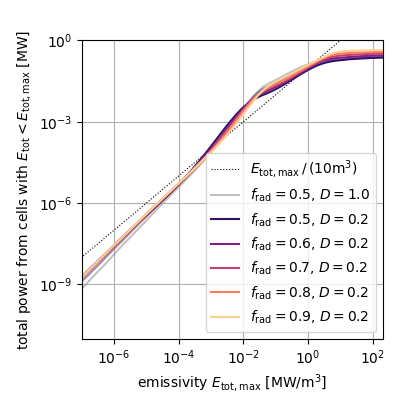

In [145]:
# check at which emissivity no power is really sent anymore
# assume each cell has same size
fig, ax = plt.subplots(figsize=(4,4.1))
MW_fac = 1e-6
gv = np.load("./data/volumes.npy")
N = 200

x = np.logspace(-8, 6, 40)
ax.plot(x, x/10, ls=":", c="k", lw=0.8, label=r"${E_{\mathrm{tot, max}}}\,/\,({10\mathrm{m}^3})$")

aip = []
for i, cpath in enumerate(all_paths[::-1]):
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)

    bin_edges = np.logspace(np.log10(1e-5), np.log10(3e8), N+1)
    midpts = (bin_edges[1:] + bin_edges[:-1])/2
    bin_map = np.digitize(dsez.data, bin_edges)
    
    cell_power = dsez.data * gv
    power_values = np.zeros(N)  # W
    
    for ii in range(N):
        power_values[ii] = cell_power[bin_map == ii].sum()
        
    integrated_power = power_values.cumsum()
    aip.append(integrated_power)
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    clr = get_color(frad, d=diffval)
    label = "$f_{\mathrm{rad}} =$" + str(frad) + ", $D=$" + str(diffval)
    label = label if i in {0,2,3,4,5,6} else None
    ax.plot(MW_fac*midpts, MW_fac*integrated_power, color=clr, label=label)
    
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim((1e-11,1e0)); ax.set_xlim((1e-7,2e2))
ax.set_yticks([1e-9, 1e-6, 1e-3, 1e0])
ax.set_xticks([1e-6, 1e-4, 1e-2, 1e0, 1e2])
ax.legend(loc=4)
ax.set_ylabel("total power from cells with $E_{\mathrm{tot}} < E_{\mathrm{tot, max}}$ [MW]")
ax.set_xlabel("emissivity $E_{\mathrm{tot, max}}$ [MW/m$^3$]")
ax.set_title("$f_{\mathrm{rad}} = 0.9$, $D = 0.2$ m$^2$/s", color="white")
fig.tight_layout()
ax.grid()

aip2 = np.array([(aipp/aipp.max() > 1/1000).argmax() for aipp in aip])

fig.savefig(f"{plotfolder}/emissivity-contributions.pdf")
fig.savefig(f"{plotfolder}/emissivity-contributions.png", dpi=200, transparent=True)

<IPython.core.display.Javascript object>


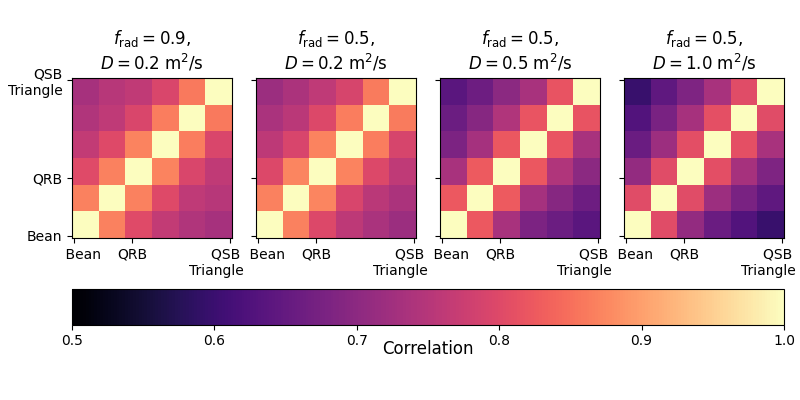

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
loss = 0.3370616007194245
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
loss = 0.3370616007194245
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc
loss = 0.3370616007194245
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc
loss = 0.3370616007194245


In [198]:
import matplotlib.colors as colors
relevant_paths = [cpaths[0], cpaths[4], diff_paths[1], diff_paths[2]]
plt.close("all")
phibounds = np.linspace(0, 36, 7)
mesh = np.meshgrid(phibounds, phibounds)

all_corr_matricies, frads, diffvals = [], [], []
fig, axs = plt.subplots(figsize=(8,4), ncols=4, sharey=True)
for path, ax in zip(relevant_paths, axs[:]):
    frad = float(path.stem[20:24])/float(path.stem[9:13])
    diffval = float(2 if path.stem[-1]=="C" else path.stem[-2:])/10
    ds = xr.open_dataset(path)
    dsEz = ds.Ez.sum(dim="Ionization", skipna=False)
    print(path)
    # we need to remove field lines that pass a nan to not break the correlation
    # having themall 0 would be worse
    nanmask = np.logical_not(np.isnan(dsEz).any(dim="phi"))
    flat_nanmask = nanmask.data.flatten()
    flat_grid = dsEz.data.reshape((-1, len(dsEz.phi)))
    nonan_flat_grid = flat_grid[flat_nanmask]  # shape: crossecdata, phi
    print(f"loss = {1 - nonan_flat_grid.shape[0]/(len(dsEz.r)*len(dsEz.theta))}")
    
    # filter for >1kW/m^2
    more_than_1 = np.all(nonan_flat_grid > 1e3, axis=1)
    nonan_flat_grid = nonan_flat_grid[more_than_1]
    # log scale
    nonan_flat_grid = np.log10(nonan_flat_grid)
    
    corr_matrix = np.corrcoef(nonan_flat_grid, rowvar=False)
    # print(corr_matrix )

    # each toroidal computational cell is like 6 grid cells long, so lets sample only every sixth
    new_corr_matrix = corr_matrix[::6,::6]
    all_corr_matricies.append(new_corr_matrix)
    frads.append(frad)
    diffvals.append(diffval)

    cb = ax.pcolormesh(*mesh, new_corr_matrix, norm=colors.PowerNorm(gamma=1, vmin=0.5, vmax=1),
                   cmap=cm.magma)
    ax.set_yticks([0.5, 13.5, 35.5]), ax.set_xticks([0.5, 13.5, 35.5])
    ax.set_yticklabels(["Bean", "QRB", "QSB\nTriangle"])
    ax.set_xticklabels(["    Bean", "QRB", "QSB  \nTriangle      "])
    ax.set_title("$f_{\mathrm{rad}} =$" + str(frad) + ",\n$D = " + str(diffval) + "$ m$^2$/s", verticalalignment="baseline")
    # Correlation between cross section emissivity values\n 
    ax.set_aspect("equal")

fig.tight_layout()
fig.subplots_adjust(wspace=0.15, hspace=0, top=1, bottom=0.15, left=0.09, right=0.98)
cbb = fig.colorbar(cb,  ax=axs.ravel().tolist(), orientation='horizontal')
cbb.set_label("Correlation", rotation=0, verticalalignment='baseline', size=12)


fig.savefig(f"{plotfolder}/cross-section-corellations.pdf")
fig.savefig(f"{plotfolder}/cross-section-corellations.png", dpi=200)

# correlation of QSB and QRB emissivities in log space with every cell removed which is not >1kW/m^3 in all crossections

In [18]:
plt.close("all")

all_corr_matricies, frads, diffvals = [], [], []
for path in all_paths:
    frad = float(path.stem[20:24])/float(path.stem[9:13])
    diffval = float(2 if path.stem[-1]=="C" else path.stem[-2:])/10
    ds = xr.open_dataset(path)
    dsEz = ds.Ez.sum(dim="Ionization", skipna=False)
    print(path)
    # we need to remove field lines that pass a nan to not break the correlation
    # having themall 0 would be worse
    nanmask = np.logical_not(np.isnan(dsEz).any(dim="phi"))
    flat_nanmask = nanmask.data.flatten()
    flat_grid = dsEz.data.reshape((-1, len(dsEz.phi)))
    nonan_flat_grid = flat_grid[flat_nanmask]  # shape: crossecdata, phi
    print(f"loss = {1 - nonan_flat_grid.shape[0]/(len(dsEz.r)*len(dsEz.theta))}")
    
    # filter for >1kW/m^2
    more_than_1 = np.all(nonan_flat_grid > 1e3, axis=1)
    nonan_flat_grid = nonan_flat_grid[more_than_1]
    # log scale
    nonan_flat_grid = np.log10(nonan_flat_grid)
    
    corr_matrix = np.corrcoef(nonan_flat_grid, rowvar=False)
    # print(corr_matrix )

    # each toroidal computational cell is like 6 grid cells long, so lets sample only every sixth
    new_corr_matrix = corr_matrix[::6,::6]
    all_corr_matricies.append(new_corr_matrix)
    frads.append(frad)
    diffvals.append(diffval)

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
loss = 0.3370616007194245
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.00-C.nc
loss = 0.3370616007194245
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc
loss = 0.3370616007194245
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.00-C.nc
loss = 0.3370616007194245
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
loss = 0.3370616007194245
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc
loss = 0.3370616007194245
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc
loss = 0.3370616007194245


<IPython.core.display.Javascript object>


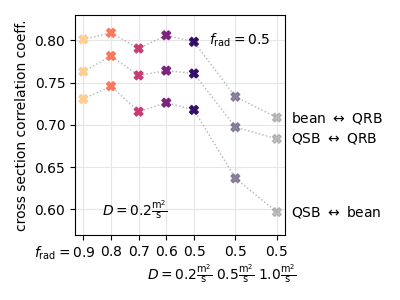

In [95]:
fig, ax = plt.subplots(figsize=(4,3))
corr_stack = np.array(all_corr_matricies)
x_ticks = [0,1,2,3,4,5.5,7]

colors = [get_color(frad, diffval) for (frad, diffval) in zip(frads, diffvals)]
xtlabels = ( ["$f_{\mathrm{rad}} = 0.9$         ",
             "$0.8$", "$0.7$","$0.6$", "$0.5$\n$D=0.2$" + r"$\frac{\mathrm{m}^2}{\mathrm{s}^{{\,}}}$" + "       ",
              "$0.5$\n$0.5$" + r"$\frac{\mathrm{m}^2}{\mathrm{s}^{{\,}}}$", 
              "$0.5$\n$1.0$" + r"$\frac{\mathrm{m}^2}{\mathrm{s}^{{\,}}}$"] )
xtlabels = xtlabels
xtpos = x_ticks
ax.set_xticks(x_ticks, minor=True)
ax.set_xticks(xtpos)
ax.set_xticklabels(xtlabels)

ax.set_ylim((0.57,0.83))
ax.set_xlim((-0.3,7.3))
ax.text(1.85, 0.6, "$D = " + "0.2" + r"\frac{\mathrm{m}^2}{\mathrm{s}^{{\,}}}$", va="center", ha="center")
ax.text(5.65, 0.8, "$f_{\mathrm{rad}} = 0.5$", va="center", ha="center")
ax.vlines(4, 0, 1, color="k", lw=0.5, zorder=1)

QSB_QRB_corr = corr_stack[:, 2, 5]
ax.scatter(x_ticks, QSB_QRB_corr, c=colors, zorder=10, marker="X", s=40)
ax.plot(x_ticks, QSB_QRB_corr, c=3*(0.7,), lw=1, ls=":")
ax.text(7.5, QSB_QRB_corr[-1], "QSB $\leftrightarrow$ QRB", ha="left", va="center")
QSB_bean_corr = corr_stack[:, 0, 5]
ax.scatter(x_ticks, QSB_bean_corr, c=colors, zorder=10, marker="X", s=40)
ax.plot(x_ticks, QSB_bean_corr, c=3*(0.7,), lw=1, ls=":")
ax.text(7.5, QSB_bean_corr[-1], "QSB $\leftrightarrow$ bean", ha="left", va="center")
bean_QRB_corr = corr_stack[:, 2, 0]
ax.scatter(x_ticks, bean_QRB_corr, c=colors, zorder=10, marker="X", s=40)
ax.plot(x_ticks, bean_QRB_corr, c=3*(0.7,), lw=1, ls=":")
ax.text(7.5, bean_QRB_corr[-1], "bean $\leftrightarrow$ QRB", ha="left", va="center")


ax.grid(axis="both", c=3*(0.9,))
ax.set_ylabel("cross section correlation coeff.")
fig.tight_layout()    

fig.savefig(f"{plotfolder}/cross-section-corellation-change.pdf")
fig.savefig(f"{plotfolder}/cross-section-corellation-change.png", dpi=200)


# heatmap

<IPython.core.display.Javascript object>


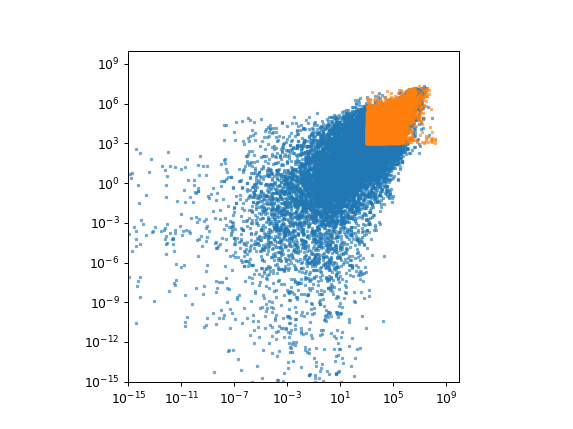

(1e-15, 10000000000.0)

In [477]:
fig, ax = plt.subplots()
ax.set_aspect("equal")


ds = xr.open_dataset(cpaths[-1])
dsEz = ds["Ez"].sum(dim="Ionization", skipna=False)
dsEz_flat = dsEz.data.reshape((-1, len(dsEz.phi)))

QRB_ez, QSB_ez = dsEz_flat[:,13], dsEz_flat[:,35]
ax.scatter(QRB_ez, QSB_ez, marker=",", s=1, alpha=0.5)

QRB_ez, QSB_ez = dsEz_flat[:,0], dsEz_flat[:,35]

# filter stuff
#more_than_1 = (QRB_ez*QSB_ez) > 1
more_than_1 = np.logical_and((QRB_ez > 1e3), (QSB_ez > 1e3))
QRB_ez, QSB_ez = QRB_ez[more_than_1], QSB_ez[more_than_1]

ax.scatter(QRB_ez, QSB_ez, marker=",", s=1, alpha=0.5)


#ax.set_yscale("symlog", linthresh=1); ax.set_ylim((1e-15, 1e10))
#ax.set_xscale("symlog", linthresh=1); ax.set_xlim((1e-15, 1e10))
ax.set_yscale("log"); ax.set_ylim((1e-15, 1e10))
ax.set_xscale("log"); ax.set_xlim((1e-15, 1e10))

In [110]:
import scipy.stats as stats
def density_estimation(m1, m2, x, y, bw):
    X, Y = np.meshgrid(x, y)                                                
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values, bw_method=bw)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

In [111]:
ds = xr.open_dataset(diff_paths[0])
dsEz = ds["Ez"].sum(dim="Ionization", skipna=False)
dsEz_flat = dsEz.data.reshape((-1, len(dsEz.phi)))

nanfilter = np.logical_not(np.isnan(dsEz_flat[:,13] + dsEz_flat[:,35]))
QRB_ez, QSB_ez = dsEz_flat[:,13][nanfilter], dsEz_flat[:,35][nanfilter]
logQRB_ez, logQSB_ez = np.log10(QRB_ez), np.log10(QSB_ez)

In [112]:
scale_size = np.linspace(-11, 8, 100)
X, Y, Z = density_estimation(logQRB_ez, logQSB_ez, scale_size, scale_size, bw=0.05)
#np.logspace(-14, 11, 100)
#X, Y, Z = density_estimation(QRB_ez, QSB_ez, scale_size, scale_size, bw=None)
#Z = Z/Z.max()

In [113]:
import scipy as sp

<IPython.core.display.Javascript object>


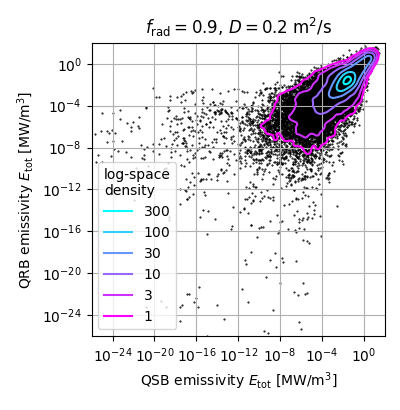

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Log scale: values of z <= 0 have been masked


In [167]:
fig, ax = plt.subplots(figsize=(4,4.1))
ax.set_aspect("equal")
philip_map = cm.Greys.copy()
philip_map.set_under((0,0,0), alpha=0)
MW_fac = 1e-6
path = paths[0]

ds = xr.open_dataset(path)
dsEz = ds["Ez"].sum(dim="Ionization", skipna=False)
dsEz_flat = dsEz.data.reshape((-1, len(dsEz.phi)))

nanfilter = np.logical_not(np.isnan(dsEz_flat[:,13] + dsEz_flat[:,35]))
QRB_ez, QSB_ez = dsEz_flat[:,13][nanfilter], dsEz_flat[:,35][nanfilter]
logQRB_ez, logQSB_ez = np.log10(QRB_ez), np.log10(QSB_ez)

scale_size = np.linspace(-5, 9, 100)
Z, xedges, yedges = np.histogram2d(logQRB_ez, logQSB_ez, bins=scale_size)
X, Y = np.meshgrid(xedges, yedges)
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]

mid_Z = (Z[1:,1:] + Z[:-1,1:] + Z[:-1,:-1] + Z[1:,:-1])/4
mid_X = (X[1:,1:] + X[:-1,1:] + X[:-1,:-1] + X[1:,:-1])/4
mid_Y = (Y[1:,1:] + Y[:-1,1:] + Y[:-1,:-1] + Y[1:,:-1])/4

sigma = [1.5, 1.5]
smooth_Z = sp.ndimage.filters.gaussian_filter(Z, sigma, mode='constant')

unlog_X, unlog_Y = 10**mid_X, 10**mid_Y # X, Y # 
CS = ax.contour(MW_fac*unlog_X, MW_fac*unlog_Y, smooth_Z, locator=ticker.LogLocator(),
                levels=np.array([1, 3, 10, 30, 100, 300]), cmap=cm.cool_r, zorder=3)

ax.set_yscale("log")
ax.set_xscale("log")
#ax.set_yscale("linear")
#ax.set_xscale("linear")
ax.scatter(MW_fac*QSB_ez, MW_fac*QRB_ez, marker=".", s=1, zorder=1, c="k", alpha=1)

#cbar = fig.colorbar(cbb, extend="both") #cbar.add_lines(cbb)
labels = ["$300$", "$100$", "$30$", "$10$", "$3$", "$1$"]
proxy = [mpl.lines.Line2D([0,1], [0,], c = pc.get_edgecolor()[0]) for pc in CS.collections[::-1]]

ax.legend(proxy, labels, title="log-space\ndensity", loc=3)
ax.set_xlabel("QSB emissivity $E_{\mathrm{tot}}$ [MW/m$^3$]")
    
ax.set_ylabel("QRB emissivity $E_{\mathrm{tot}}$ [MW/m$^3$]")

ax.set_aspect("equal")
ax.set_title("$f_{\mathrm{rad}} = 0.9$, $D = 0.2$ m$^2$/s")
ax.grid(zorder=2)
ax.set_xticks(MW_fac*np.array([1e-18, 1e-14, 1e-10, 1e-6, 1e-2, 1e2, 1e6]))
ax.set_ylim((MW_fac*1e-20, MW_fac*1e8))
ax.set_yticks(MW_fac*np.array([1e-18, 1e-14, 1e-10, 1e-6, 1e-2, 1e2, 1e6]))
ax.set_xlim((MW_fac*1e-20, MW_fac*1e8))

#fig.subplots_adjust(wspace=0.2, hspace=0, top=1, bottom=0, left=0.05, right=1)
fig.tight_layout()
fig.tight_layout()

fig.savefig(f"{plotfolder}/crossection-corellation-contours-single.pdf")
fig.savefig(f"{plotfolder}/crossection-corellation-contours-single.png", dpi=200)
# high frad, low diffusion

<IPython.core.display.Javascript object>


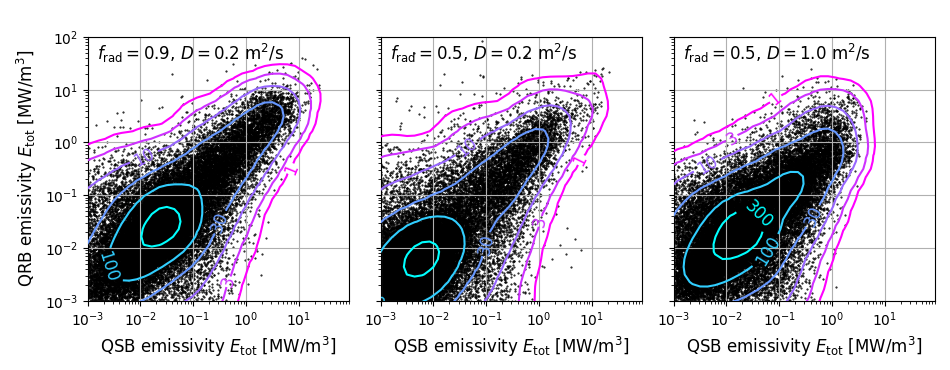

(50460,)


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Log scale: values of z <= 0 have been masked


(50460,)


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Log scale: values of z <= 0 have been masked


(50460,)


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Log scale: values of z <= 0 have been masked


In [168]:
def fmt(x):
    x = x
    s = f"{x:.0f}"
    return s

fig, axs = plt.subplots(figsize=(9.5,3.7), ncols=3, sharey=True)
philip_map = cm.Greys.copy()
philip_map.set_under((0,0,0), alpha=0)
MW_fac = 1e-6


for path, ax in zip([paths[0],diff_paths[0],diff_paths[-1]], axs[:]):  # high frad, low frad, low frad high diffusion
    ds = xr.open_dataset(path)
    dsEz = ds["Ez"].sum(dim="Ionization", skipna=False)
    dsEz_flat = dsEz.data.reshape((-1, len(dsEz.phi)))

    nanfilter = np.logical_not(np.isnan(dsEz_flat[:,13] + dsEz_flat[:,35]))
    QRB_ez, QSB_ez = dsEz_flat[:,13][nanfilter], dsEz_flat[:,35][nanfilter]
    logQRB_ez, logQSB_ez = np.log10(QRB_ez), np.log10(QSB_ez)
    print((logQRB_ez).shape)

    scale_size = np.linspace(2, 9, 50)
    Z, xedges, yedges = np.histogram2d(logQRB_ez, logQSB_ez, bins=scale_size)
    X, Y = np.meshgrid(xedges, yedges)
    extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]

    mid_Z = (Z[1:,1:] + Z[:-1,1:] + Z[:-1,:-1] + Z[1:,:-1])/4
    mid_X = (X[1:,1:] + X[:-1,1:] + X[:-1,:-1] + X[1:,:-1])/4
    mid_Y = (Y[1:,1:] + Y[:-1,1:] + Y[:-1,:-1] + Y[1:,:-1])/4

    sigma = [1.5, 1.5]
    smooth_Z = sp.ndimage.filters.gaussian_filter(Z, sigma, mode='constant')

    unlog_X, unlog_Y = 10**mid_X, 10**mid_Y # X, Y # 
    CS = ax.contour(MW_fac*unlog_X, MW_fac*unlog_Y, smooth_Z, locator=ticker.LogLocator(),
                    levels=np.array([1, 3, 10, 30, 100, 300]), cmap=cm.cool_r, zorder=3)

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.scatter(MW_fac*QSB_ez, MW_fac*QRB_ez, marker=".", s=1, zorder=1, c="k", alpha=1)

    #cbar = fig.colorbar(cbb, extend="both") #cbar.add_lines(cbb)
    labels = ["$80$", "$30$", "$10$", "$3$", "$1$"]
    proxy = [mpl.lines.Line2D([0,1], [0,], c = pc.get_edgecolor()[0]) for pc in CS.collections[::-1]]

    #ax.legend(proxy, labels, title="log-space\ndensity", loc=4)
    ax.set_xlabel("QSB emissivity $E_{\mathrm{tot}}$ [MW/m$^3$]", fontsize=12)
    ax.clabel(CS, fmt=fmt, inline=1, inline_spacing=-1, fontsize=12)
    
axs[0].set_ylabel("QRB emissivity $E_{\mathrm{tot}}$ [MW/m$^3$]", fontsize=12)
titles = ["$f_{\mathrm{rad}} = 0.9$, $D = 0.2$ m$^2$/s", "$f_{\mathrm{rad}} = 0.5$, $D = 0.2$ m$^2$/s", "$f_{\mathrm{rad}} = 0.5$, $D = 1.0$ m$^2$/s"]

for i in range(3): 
    axs[i].set_aspect("equal")
    #axs[i].set_title(titles[i])
    axs[i].text(1.5e-3, 0.8e2, titles[i], va="top", ha="left", fontsize=12)
    axs[i].grid(zorder=2)
    # axs[i].set_xticks(MW_fac*np.array([1e-6, 1e-3, 1e-0, 1e3, 1e6]))
    axs[i].set_ylim((MW_fac*1e3, MW_fac*1e8))
    # axs[i].set_yticks(MW_fac*np.array([1e-6, 1e-3, 1e-0, 1e3, 1e6]))
    axs[i].set_xlim((MW_fac*1e3, MW_fac*0.9e8))

#fig.subplots_adjust(wspace=0.2, hspace=0, top=1, bottom=0, left=0.05, right=1)
fig.tight_layout()
fig.tight_layout()

fig.savefig(f"{plotfolder}/crossection-corellation-contours.pdf")
fig.savefig(f"{plotfolder}/crossection-corellation-contours.png", dpi=200)

In [112]:
fig.tight_layout()

# look at signgle islands

In [129]:
relevant_paths = [cpaths[0], cpaths[2], cpaths[4], diff_paths[2]]
currp = -2
QRB_index = 13

cpath = relevant_paths[currp]
ds = xr.open_dataset(cpath)
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
dsez = ds.Ez.sum(dim="Ionization", skipna=False)

<IPython.core.display.Javascript object>


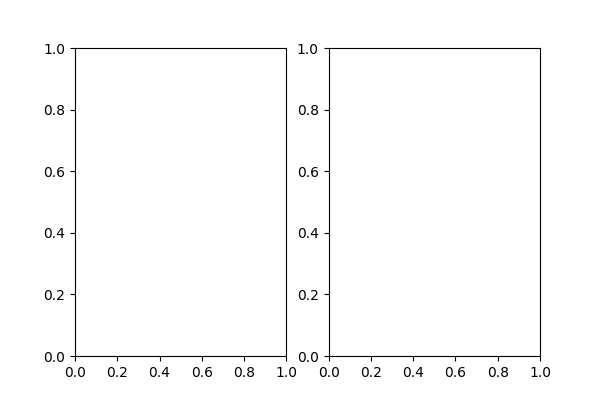

NameError: name 'R' is not defined

In [100]:
fig, axs = plt.subplots(figsize=(6,4), ncols=2)  # figsize=(3,5)
QRB_index, QSB_index = 13, 35
MW_fac = 1e-6
philip_map = cm.magma
#philip_map.set_bad("k", alpha=0.1)

# qrb low
cb = axs[0].pcolormesh(R, Z, MW_fac * dsez.isel(phi=QRB_index), 
                   cmap=philip_map, norm=colors.LogNorm(vmin=1e-3, vmax=1e1)) # , vmax=2e6)
axs[0].set_aspect("equal")

# qrb high
cb = axs[1].pcolormesh(R, Z, MW_fac * dsez.isel(phi=QSB_index), 
                   cmap=philip_map, norm=colors.LogNorm(vmin=1e-3, vmax=1e1), zorder=2) # , vmax=2e6)
axs[1].set_aspect("equal")

# islands
for axi in range(2):
    for i,file in enumerate(Path("./data/").glob("further*")):       
        x, y = np.load(file)
        if i == 0:
            axs[axi].plot(x,y, c="greenyellow", lw=1, ls="-.", label="flux surfaces")
            axs[axi].legend(loc=2)
        else: axs[axi].plot(x,y, c="greenyellow", lw=1, ls="-.")
            
    for i,file in enumerate(Path("./data/").glob("island*")):
        x, y = np.load(file)
        if i == 0:
            axs[axi].plot(x,y, c="lime", lw=1, ls="-.", label="islands")
            axs[axi].legend(loc=2)
        else: axs[axi].plot(x,y, c="lime", lw=1, ls="-.")

    
for axi in range(2):   
    axs[axi].set_ylim((-0.9, 1.05)); axs[axi].set_xlim((4.9, 6.25))
    #ax.set_ylim((0, 1)); ax.set_xlim((5.3, 6.3))
    axs[axi].axes.xaxis.set_ticklabels([])
    axs[axi].axes.yaxis.set_ticklabels([])
    axs[axi].axes.xaxis.set_visible(False)
    axs[axi].axes.yaxis.set_visible(False)
    axs[axi].set_xlim((4.9,5.3))
    axs[axi].set_ylim((0.5,1.1))
    
axs[0].set_title("QRB cross section", verticalalignment='top')
axs[1].set_title("QSB mapped to QRB", verticalalignment='top')

# cbb = fig.colorbar(cb, ax=axs.ravel().tolist(), orientation='horizontal')
# cbb.set_label("mean emissivity $E^z$ along field line [MW/m$^3$]", rotation=0, verticalalignment='top')
fig.tight_layout()
cbb = fig.colorbar(cb, ax=axs.ravel().tolist(), extend="both")
cbb.set_label("$E_{\mathrm{tot}}$ [MW/m$^3$]", rotation=270, verticalalignment='baseline')

thts = [55, 120, 250, 405, 460]
rs = [6, 12, 6, 13, 12]
for i in range(5):
    for axi in range(2):
        axs[axi].text(ds.R_bounds[rs[i],thts[i],13,0,0,0], ds.z_bounds[rs[i],thts[i],13,0,0,0], 
                    f"{i+1}", size=16, zorder=1e4, c="k", ha="center", va="center")


<IPython.core.display.Javascript object>


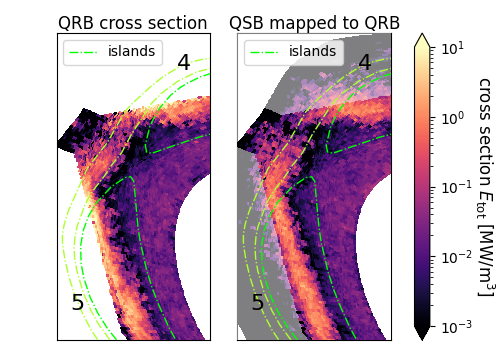

/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))


In [103]:
# var 1/2
#cpath = relevant_paths[0]
#cpath = relevant_paths[-2]
cpath = relevant_paths[-1]

ds = xr.open_dataset(cpath)
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
dsez = ds.Ez.sum(dim="Ionization", skipna=False)

fig, axs = plt.subplots(figsize=(5,3.6), ncols=2)  # figsize=(3,5)
QRB_index, QSB_index = 13, 35
MW_fac = 1e-6
philip_map = cm.magma
#philip_map.set_bad("k", alpha=0.1)

# qrb low
cb = axs[0].pcolormesh(R, Z, MW_fac * dsez.isel(phi=QRB_index), 
                   cmap=philip_map, norm=colors.LogNorm(vmin=1e-3, vmax=1e1)) # , vmax=2e6)
axs[0].set_aspect("equal")

# qrb high
cb = axs[1].pcolormesh(R, Z, MW_fac * dsez.isel(phi=QSB_index), 
                   cmap=philip_map, norm=colors.LogNorm(vmin=1e-3, vmax=1e1), zorder=2) # , vmax=2e6)
axs[1].set_aspect("equal")
axs[1].axvspan(0, 9, facecolor="white", alpha=0.5, zorder=3) #, label="fraction of target cells")
nan_at_QRB = (np.isnan(dsez.isel(phi=QRB_index)))
nonnan_mapped = dsez.isel(phi=QSB_index).copy()
for i in range(len(dsez.r)):
    for j in range(len(dsez.theta)):
        if nan_at_QRB[i,j]:
            nonnan_mapped[i,j] = np.nan
axs[1].pcolormesh(R, Z, MW_fac * nonnan_mapped, 
                   cmap=philip_map, norm=colors.LogNorm(vmin=1e-3, vmax=1e1), zorder=4) # , vmax=2e6)

# islands
for axi in range(2):
    for i,file in enumerate(Path("./data/").glob("further*")):       
        x, y = np.load(file)
        if i == -1:
            axs[axi].plot(x,y, c="greenyellow", lw=1, ls="-.", label="flux surfaces", zorder=5)
            axs[axi].legend(loc=2)
        else: axs[axi].plot(x,y, c="greenyellow", lw=1, ls="-.", zorder=5)
            
    for i,file in enumerate(Path("./data/").glob("island*")):
        x, y = np.load(file)
        if i == 0:
            axs[axi].plot(x,y, c="lime", lw=1, ls="-.", label="islands", zorder=5)
            axs[axi].legend(loc=2)
        else: axs[axi].plot(x,y, c="lime", lw=1, ls="-.", zorder=5)
    
for axi in range(2):   
    axs[axi].set_ylim((-0.9, 1.05)); axs[axi].set_xlim((4.9, 6.25))
    #ax.set_ylim((0, 1)); ax.set_xlim((5.3, 6.3))
    axs[axi].axes.xaxis.set_ticklabels([])
    axs[axi].axes.yaxis.set_ticklabels([])
    axs[axi].axes.xaxis.set_visible(False)
    axs[axi].axes.yaxis.set_visible(False)
    axs[axi].set_xlim((4.9,5.2))
    axs[axi].set_ylim((0.5,1.1))
    
axs[0].set_title("QRB cross section", verticalalignment='center', size=12)
axs[1].set_title("QSB mapped to QRB", verticalalignment='center', size=12)

# cbb = fig.colorbar(cb, ax=axs.ravel().tolist(), orientation='horizontal')
# cbb.set_label("mean emissivity $E^z$ along field line [MW/m$^3$]", rotation=0, verticalalignment='top')
fig.tight_layout()
cbb = fig.colorbar(cb, ax=axs.ravel().tolist(), extend="both")
cbb.set_label("cross section $E_{\mathrm{tot}}$ [MW/m$^3$]", rotation=270, verticalalignment='baseline', size=12)

zs = [1.04, 0.57]
rs = [5.15, 4.94]
for i in range(2):
    for axi in range(2):
        axs[axi].text(rs[i], zs[i], 
                    f"{i+4}", size=16, zorder=1e4, c="k", ha="center", va="center")
        
# var 1/2
# frad = 0.9, D = 0.2
# fig.savefig(f"{plotfolder}/QSBtoQRBmap-target-island-extension-high-frad.pdf")
# fig.savefig(f"{plotfolder}/QSBtoQRBmap-target-island-extension-high-frad.png", dpi=200)
# frad = 0.5, D = 0.2
# fig.savefig(f"{plotfolder}/QSBtoQRBmap-target-island-extension-low-frad.pdf")
# fig.savefig(f"{plotfolder}/QSBtoQRBmap-target-island-extension-low-frad.png", dpi=200)
# frad = 0.5, D = 1.0
fig.savefig(f"{plotfolder}/QSBtoQRBmap-target-island-extension-high-diffusion.pdf")
fig.savefig(f"{plotfolder}/QSBtoQRBmap-target-island-extension-high-diffusion.png", dpi=200)

In [596]:
relevant_pathsvant_pathsvant_pathsvant_paths

[PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc')]

In [374]:
# var 1/2

<xarray.DataArray 'Ez' ()>
array(True)

# section mapping plot

<IPython.core.display.Javascript object>


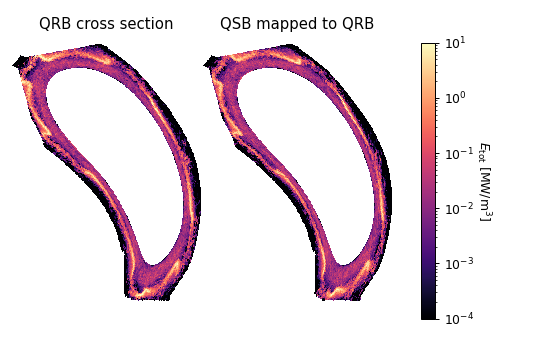

/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [593]:
#ds = xr.open_dataset("./../atomdatpy/NetCDFs-new/N03.00_P05.00_D05_C04.00-TEST.nc")
ds = xr.open_dataset(paths[0])
#ds = xr.open_dataset(cpaths[0])
phi, otherphi = 13, 35 # QRB, QSB
R, Z = crossec_pcolorgrid(ds, phi=phi)
cmap = cm.magma
MW_fac = 1e-6


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,4), sharey=True)
fig.subplots_adjust(wspace=-0.1, hspace=0)
R, Z = crossec_pcolorgrid(ds, phi=phi)


vmin, vmax = MW_fac*1e2, MW_fac*1e7
# some Ez
QRB_data = MW_fac*ds["Ez"].isel(phi=phi).sum(dim="Ionization", skipna=False)
axs[0].set_aspect("equal")
axs[0].pcolormesh(R, Z, QRB_data, cmap=cmap,
                 norm=colors.LogNorm(vmin=vmin, vmax=vmax))
axs[0].set_title("QRB cross section", verticalalignment='top')
# some Ez
raw_mapped = MW_fac*ds["Ez"].isel(phi=otherphi).sum(dim="Ionization", skipna=False).copy()
for i, (l1, l2) in enumerate(zip(np.isnan(QRB_data), raw_mapped)):
    for j, (v1, v2) in enumerate(zip(l1, l2)):
        if v1:
            raw_mapped[i,j] = np.nan
axs[1].set_aspect("equal")
im = axs[1].pcolormesh(R, Z, raw_mapped, cmap=cmap,
                 norm=colors.LogNorm(vmin=vmin, vmax=vmax))
axs[1].set_title("QSB mapped to QRB", verticalalignment='top')

for i in range(2):
    axs[i].set_aspect("equal")
    axs[i].axes.xaxis.set_ticklabels([])
    axs[i].axes.yaxis.set_ticklabels([])
    axs[i].axes.xaxis.set_visible(False)
    axs[i].axes.yaxis.set_visible(False)
    #axs[i].set_ylim(0, axs[i].get_ylim()[1]*0.9)
    axs[i].set_ylim(axs[i].get_ylim()[0]*0.92, axs[i].get_ylim()[1]*0.92)
    axs[i].set_xlim(axs[i].get_xlim()[0]*1.02, axs[i].get_xlim()[1]*0.974)
    axs[i].axis('off')

    
cbb = fig.colorbar(im,  ax=axs.ravel().tolist()) # , orientation='horizontal')
cbb.set_label("$E_{\mathrm{tot}}$ [MW/m$^3$]", rotation=270, verticalalignment='baseline')

fig.tight_layout()

fig.subplots_adjust(wspace=-0.1, hspace=0, top=1, bottom=0, left=0, right=0.75)#
#fig.savefig(f"{plotfolder}/QSBtoQRBmap.pdf")
#fig.savefig(f"{plotfolder}/QSBtoQRBmap.png", dpi=200)

# factor mapping

In [476]:
# low value mapping is useless, lets map all of them to 0
# specifically everything below 1kW/m^2

In [140]:
# setup
def mapping_plot(ds):
    MW_fac = 1e-6
    QRB_index, QSB_index = 13, 35
    dsEz = ds["Ez"].sum(dim="Ionization", skipna=False)
    fig, axs = plt.subplots(figsize=(5.5,3.6), ncols=2)
    cmap = cm.coolwarm

    # calculation of relevant data
    QRB_ez, QSB_ez = dsEz.isel(phi=QRB_index), dsEz.isel(phi=QSB_index)
    R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
    alp_min, alp_max = -3, -2
    alpha_data = ( np.clip(np.nan_to_num(np.log10(MW_fac*np.minimum(QRB_ez, QSB_ez))), a_min=alp_min, a_max=alp_max)-alp_min )/(alp_max-alp_min)

    v_data1 = QRB_ez/QSB_ez
    im1 = axs[0].pcolormesh(R, Z, v_data1, alpha=alpha_data, zorder=5,
                       cmap=cmap, norm=colors.LogNorm(vmin=1e-1, vmax=1e1))
    axs[0].set_title("QRB / QSB")
    axs[0].set_aspect("equal")

    v_data2 = MW_fac* (QRB_ez - QSB_ez)
    im2 = axs[1].pcolormesh(R, Z, v_data2, alpha=alpha_data, zorder=5,
                       cmap=cmap, norm=colors.SymLogNorm(linthresh=1e-2, vmin=-5e0, vmax=5e0))
    axs[1].set_title("QRB - QSB")
    axs[1].set_aspect("equal")

    # islands 
    zs = [1.04, 0.57]; rs = [5.15, 4.94]
    pos_islands = sorted(list(Path("./data/").glob("island*")))
    for i,file in enumerate([pos_islands[0], pos_islands[2]]):
        x, y = np.load(file)
        for ax in axs:
            ax.text(rs[i], zs[i], f"{i+4}", size=16, zorder=9, c="k", ha="center", va="center")
            ax.set_xlim((4.9,5.2))
            ax.set_ylim((0.5,1.1))
            ax.axes.xaxis.set_ticklabels([])
            ax.axes.yaxis.set_ticklabels([])
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            if i == 0:
                ax.plot(x,y, c="lime", lw=1, ls="-.", label="islands", zorder=10)
                ax.legend(loc=2)
            else: ax.plot(x,y, c="lime", lw=1, ls="-.", zorder=10)       


    cbb = fig.colorbar(im1, extend="both", ax=axs[0]) # , location="left")
    cbb.set_label("$E_{\mathrm{tot,QRB}} / E_{\mathrm{tot,QSB}}$ [1]", rotation=270, verticalalignment='center')
    cbb = fig.colorbar(im2, extend="both", ax=axs[1])
    cbb.set_label("$E_{\mathrm{tot,QRB}} - E_{\mathrm{tot,QSB}}$ [MW/m$^3$]", rotation=270, verticalalignment='center')
    fig.tight_layout()
    return fig, axs

In [135]:
relevant_paths

[PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc'),
 PosixPath('../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc')]

In [136]:
# as we see here, linear function mapping does not maske sense

<IPython.core.display.Javascript object>


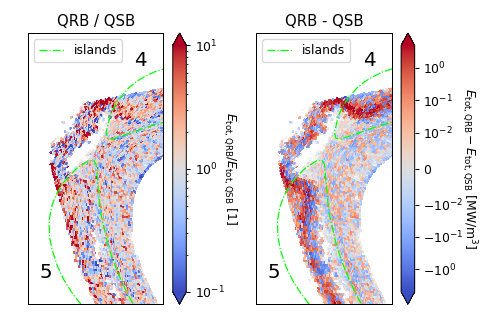

/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))


In [141]:
fig, axs = mapping_plot(xr.open_dataset(relevant_paths[0]))
fig.savefig(f"{plotfolder}/linear-map-f=0.9-d=0.2.pdf")
fig.savefig(f"{plotfolder}/linear-map-f=0.9-d=0.2.png", dpi=200)

<IPython.core.display.Javascript object>


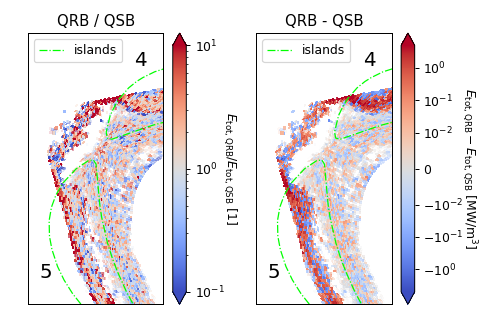

/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))


In [142]:
fig, axs = mapping_plot(xr.open_dataset(relevant_paths[1]))
fig.savefig(f"{plotfolder}/linear-map-f=0.5-d=0.2.pdf")
fig.savefig(f"{plotfolder}/linear-map-f=0.5-d=0.2.png", dpi=200)

<IPython.core.display.Javascript object>


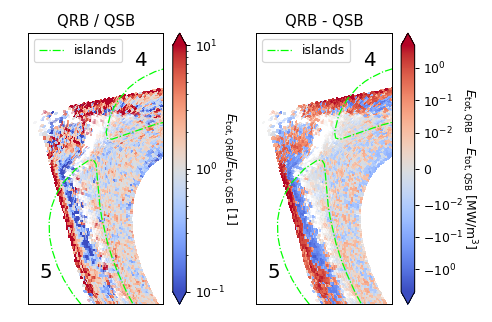

/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/u/phg/.local/lib/python3.7/site-packages/matplotlib/colors.py:1618: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))


In [143]:
fig, axs = mapping_plot(xr.open_dataset(relevant_paths[3]))
fig.savefig(f"{plotfolder}/linear-map-f=0.5-d=1.0.pdf")
fig.savefig(f"{plotfolder}/linear-map-f=0.5-d=1.0.png", dpi=200)